#**Predicción de series temporales multivariadas con Tensor Flow**

## LUZ ANGELA MOSQUERA DAZA - HECTOR ALBERTO CHICA RAMIREZ

##**Problema**

Predecir un indicador de gestión medido a nivel diario en función de su propia historia y de otros indicadores medidos simultáneamente

##**Solución propuesta-Técnicas IA-AP**

Ver el problema en un contexto de series de tiempo y resolverlo mediante redes neuronales recurrentes (LSTM o GRU)

##**Resultados**
Se analizaron 4 casos a partir de una base de 7 indicadores con 9584 registros.

La partición fue 70-20-10 para entrenamiento, validación y prueba.
Los casos:

1. Predicción un paso adelante de una variable
2. Predicción un paso adelante de las 7 variables
3. Predicción un varios pasos adelante de una variable
4. Predicción un varios pasos adelante de las 7 variables

Se utilizaron redes LSTM, con dropout tanto en la transformación lineal de las entradas, como en la trasnformación lineal del estado recurrente.

Se utilizó la activacion RELU en lugar de la activación default tangente hiperbólica TANH.

En términos generales:
1. El dropout evitó el sobreajuste, en el caso cuatro fue necesario incrementar la fracción de 0.2 a 0.3 para lograr el cometido
2. Las predicciones no fueron buenas en ninguno de los casos, aun cuando se probaron muchas longitudes de ventana de historia y algunas longitudes de ventana de predicción. Además, varios modelos cambiando el número de capas LSTM y variando el número de unidades de cada una de ellas.
3. Dado lo sucedido con las predicciones de prueba, el modelo aún no está listo para ser utilizado en producción. 



##**Recomendaciones y comentarios**
1. Seguir variando la fracción dropout.
2. Seguir probando longitudes de venana de historia y su efecto en la predicción.
3. Probar modelos nuevos.

Nuestro comentario del proyecto y en general del diplomado:

El conocimiento adquirido, que en nuestro caso particular empezaba en un nivel cero, nos hizo recorrer un camino nuevo en el análisis de series de tiempo, y aunque no logramos llegar a predicciones satisfactorias logramos iniciar un proceso que continuaremos en nuestro ejercicio diario estudiando, consultando y probando las técnicas AP no solo en ésta sino en varias áreas de la analítica.

##DESARROLLO DEL TRABAJO
El código y los pasos utilizados a continuación se adaptaron del cuaderno de ayuda que proporciona TensorFlow, https://www.tensorflow.org/tutorials/structured_data/time_series

## 1a. Paquetes

In [2]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

mpl.rcParams['figure.figsize'] = (16, 12)
mpl.rcParams['axes.grid'] = False

## 1b. Configuración de la TPU

In [3]:
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)
strategy = tf.distribute.experimental.TPUStrategy(resolver)

Running on TPU  ['10.27.28.162:8470']
INFO:tensorflow:Initializing the TPU system: grpc://10.27.28.162:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.27.28.162:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


## 2. Datos

In [76]:
import os
#os.chdir("/tmp")
os.getcwd()

from google.colab import drive
drive.mount('/content/gdrive')

ruta = 'gdrive/My Drive/Colab Notebooks/diplotf.csv'

df = pd.read_csv(ruta)

#df['fecha'] = pd.to_datetime(df.fecha,format='%d/%m/%Y')
#df.index = df['fecha']
date = pd.to_datetime(df.pop('fecha'),format='%d/%m/%Y')
#df.index = df['fecha']

df.head()
df.describe().T

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


,count,mean,std,min,25%,50%,75%,max
x1,9584.0,0.563165,0.115705,0.0,0.494406,5.713440e-01,0.637291,1.0
x2,9584.0,0.557921,0.130807,0.0,0.482993,5.646258e-01,0.646259,1.0
x3,9584.0,0.035645,0.092652,0.0,0.000000,4.047090e-18,0.017937,1.0
x4,9584.0,0.626664,0.154353,0.0,0.532773,6.420525e-01,0.729476,1.0
x5,9584.0,0.423977,0.124937,0.0,0.345471,4.234807e-01,0.512635,1.0
x6,9584.0,0.713334,0.166772,0.0,0.601091,7.200000e-01,0.840000,1.0
x7,9584.0,0.621933,0.107929,0.0,0.557344,6.313826e-01,0.698405,1.0


## 3. Eliminación de datos erróneos

In [77]:
w1 = df['x3']
bad_w1 = w1 <0
w1[bad_w1] = 0.0

w2 = df['x6']
bad_w2 = w2 <0
w2[bad_w2] = 0.0

w3 = df['x7']
bad_w3 = w3 <0
w3[bad_w3] = 0.0

w4 = df['x6']
bad_w4 = w4 >550
w4[bad_w4] = 550
df.describe().T

,count,mean,std,min,25%,50%,75%,max
x1,9584.0,0.563165,0.115705,0.0,0.494406,5.713440e-01,0.637291,1.0
x2,9584.0,0.557921,0.130807,0.0,0.482993,5.646258e-01,0.646259,1.0
x3,9584.0,0.035645,0.092652,0.0,0.000000,4.047090e-18,0.017937,1.0
x4,9584.0,0.626664,0.154353,0.0,0.532773,6.420525e-01,0.729476,1.0
x5,9584.0,0.423977,0.124937,0.0,0.345471,4.234807e-01,0.512635,1.0
x6,9584.0,0.713334,0.166772,0.0,0.601091,7.200000e-01,0.840000,1.0
x7,9584.0,0.621933,0.107929,0.0,0.557344,6.313826e-01,0.698405,1.0


In [78]:
df.head()

,x1,x2,x3,x4,x5,x6,x7
0,0.593326,0.659864,0.000000,0.532773,0.479202,0.943636,0.664137
1,0.406476,0.625850,0.000000,0.554629,0.445769,0.903636,0.638352
2,0.516388,0.673469,0.000000,0.532773,0.490346,0.874545,0.723482
3,0.626300,0.646259,0.000000,0.532773,0.501490,0.856364,0.722228
4,0.626300,0.673469,0.001121,0.510917,0.501490,0.941818,0.714078


## 4. Ploteo de los datos

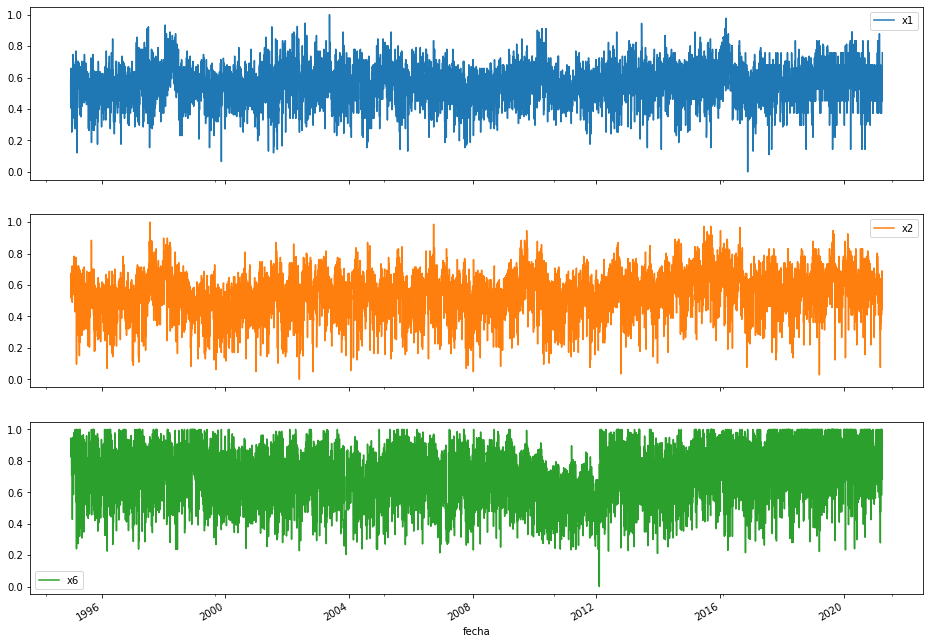

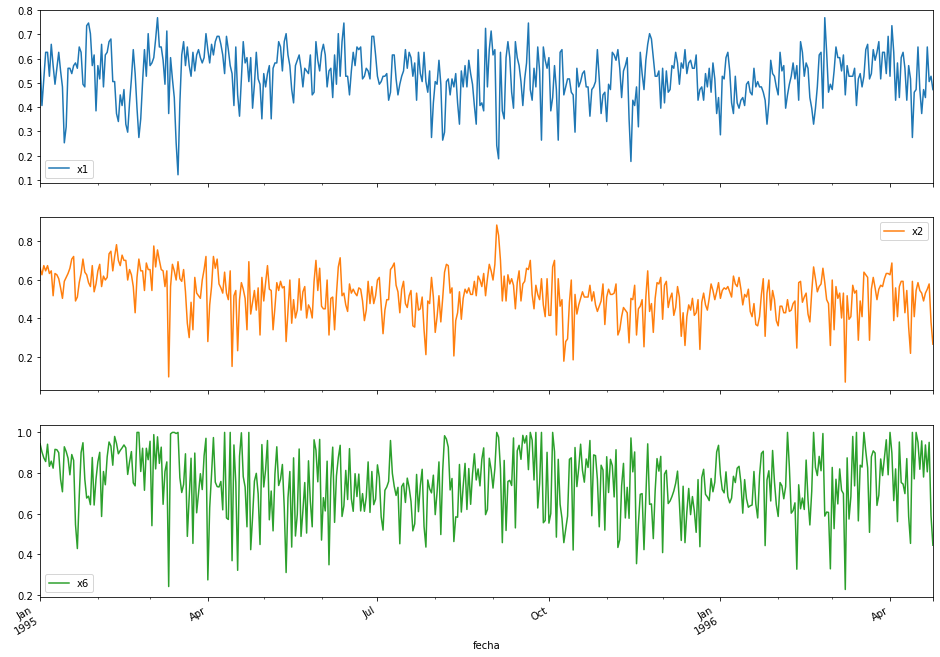

In [79]:
plot_cols = ['x1', 'x2', 'x6']
plot_features = df[plot_cols]
plot_features.index = date
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:480]
plot_features.index = date[:480]
_ = plot_features.plot(subplots=True)

## 5. Escalamiento $[0,1]$

In [80]:
dfmax=df.max()
dfmin=df.min()
dfrange=dfmax-dfmin

print('Mínimos',dfmin)
print('Máximos',dfmax)
print('rango',dfrange)

Mínimos x1    0.0
x2    0.0
x3    0.0
x4    0.0
x5    0.0
x6    0.0
x7    0.0
dtype: float64
Máximos x1    1.0
x2    1.0
x3    1.0
x4    1.0
x5    1.0
x6    1.0
x7    1.0
dtype: float64
rango x1    1.0
x2    1.0
x3    1.0
x4    1.0
x5    1.0
x6    1.0
x7    1.0
dtype: float64


In [81]:
df=(df-dfmin)/(dfmax-dfmin)


In [82]:
df.head()

,x1,x2,x3,x4,x5,x6,x7
0,0.593326,0.659864,0.000000,0.532773,0.479202,0.943636,0.664137
1,0.406476,0.625850,0.000000,0.554629,0.445769,0.903636,0.638352
2,0.516388,0.673469,0.000000,0.532773,0.490346,0.874545,0.723482
3,0.626300,0.646259,0.000000,0.532773,0.501490,0.856364,0.722228
4,0.626300,0.673469,0.001121,0.510917,0.501490,0.941818,0.714078


In [83]:
dfmax=df.max()
dfmin=df.min()
dfrange=dfmax-dfmin

print('Mínimos',dfmin)
print('Máximos',dfmax)
print('rango',dfrange)

Mínimos x1    0.0
x2    0.0
x3    0.0
x4    0.0
x5    0.0
x6    0.0
x7    0.0
dtype: float64
Máximos x1    1.0
x2    1.0
x3    1.0
x4    1.0
x5    1.0
x6    1.0
x7    1.0
dtype: float64
rango x1    1.0
x2    1.0
x3    1.0
x4    1.0
x5    1.0
x6    1.0
x7    1.0
dtype: float64


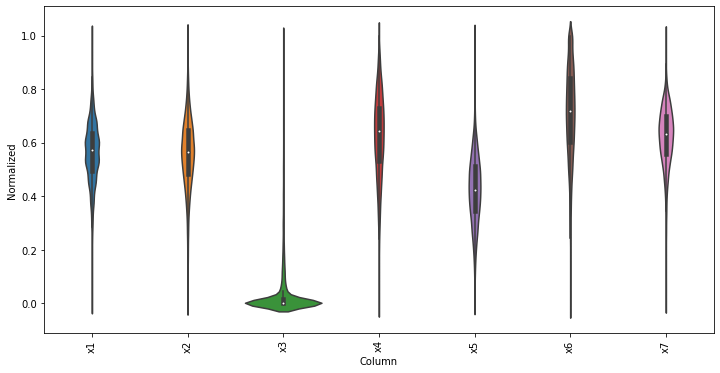

In [84]:
df1 = df
df1 = df1.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df1)
_ = ax.set_xticklabels(df.keys(), rotation=90)

## 6. Partición de los datos en Entrenamiento (70%), validación (20%) y test (10%)

In [14]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

n1=train_df.shape[0]+val_df.shape[0]+test_df.shape[0]

num_features = df.shape[1]
df.shape
print(f'Dataframe shape: {df.shape}')
print(f'Train shape: {train_df.shape}')
print(f'Val shape: {val_df.shape}')
print(f'Test shape: {test_df.shape}')
print(f'Total: {n1}')

Dataframe shape: (9584, 7)
Train shape: (6708, 7)
Val shape: (1917, 7)
Test shape: (959, 7)
Total: 9584


## 7.1.  Creación de la clase window generator 

In [15]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

## 7.2 Creación de la función SPLIT que genera inputs and outputs

In [16]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

## 7.3. Creación de la función PLOT que grafica las ventanas creadas

In [19]:
def plot(self, model=None, plot_col='x1', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

## 7.4. Creación de los `tf.data.Dataset`s
Originalmente el código crea batches de tamaño 32. Nosotros hemos probado varios tamaños y en este cuaderno dejamos 8

In [23]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=8,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

## 8. Función de entrenamiento de los modelos

Originalmente el código venía con 20 epochs pero se ha dejado en 500 dado que existe una función CALLBACK de parada con un párametro de 2 epochs sin mejora en la pérdida de validación para terminar el entrenamiento. 

Se utiliza como pérdida el cuadrado medio del error MSE, como métrica el valor medio absoluto MAE y como optimizador ADAM

In [29]:
MAX_EPOCHS = 500

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

  #para ejecutar hacer:
  #history = compile_and_fit(modelo, ventana)
  #IPython.display.clear_output()
  #val_performance['modelo'] = modelo.evaluate(ventana.val)
  #performance['modelo'] = modelo.evaluate(ventana.test, verbose=0)

#**9. CASOS DE ANALISIS**

#**9.1. Predicción de una sola variable un paso adelante**

## 9.1.1. Ventana para predecir una variable un paso adelante
En este caso se predice un paso adelante para una variable.
Estamos utilzando un pasado de 5 observaciones para predecir 1 de la variable x1. Se plotea x1 y otra de las variables (x2 en este caso) para evidenciar que se crearon labels solo para x1 


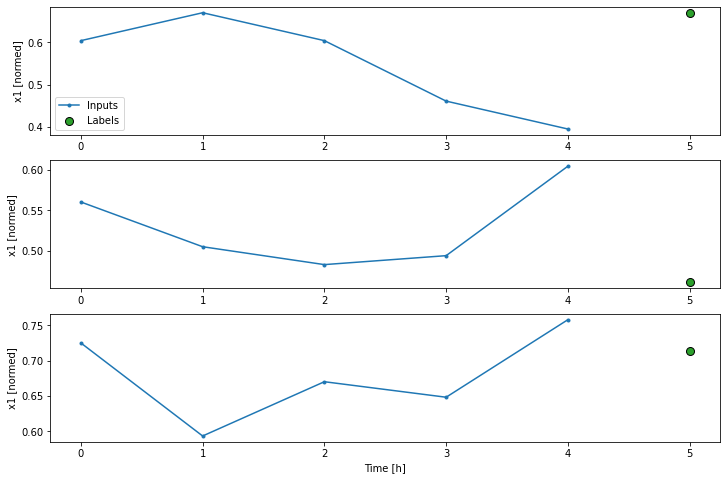

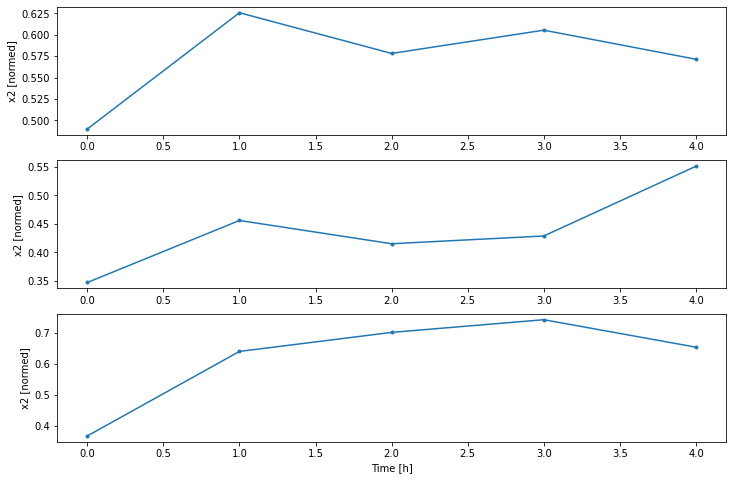

In [30]:
INPUTW=5
LABELW=1
SHIFTW=1
#Label columns=None toma todas las variables
#Cuando input y label son iguales, y shift =1 entonces es prediccion a un paso pero se grafica en el tiempo.
#Deben ser iguales, ademas es la predicción de 1 paso dado el paso anterior, ojo con eso


ventana = WindowGenerator(
    input_width=INPUTW,
    label_width=LABELW,
    shift=SHIFTW,
    label_columns=['x1'])

ventana
ventana.plot()
ventana.plot(plot_col='x2')

In [31]:
for example_inputs, example_labels in ventana.train.take(4):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (8, 5, 7)
Labels shape (batch, time, features): (8, 1, 1)
Inputs shape (batch, time, features): (8, 5, 7)
Labels shape (batch, time, features): (8, 1, 1)
Inputs shape (batch, time, features): (8, 5, 7)
Labels shape (batch, time, features): (8, 1, 1)
Inputs shape (batch, time, features): (8, 5, 7)
Labels shape (batch, time, features): (8, 1, 1)


## 9.1.2. Modelo LSTM para predecir un solo feature un período adelante (LW=1 , SHW=1)
El modelo LSTM recibe un tensor de entrada de dimensiones (8,5,7) y genera un tensor salida (8,1,1)
Por recomendación de los profesores se utiliza DROPOUT tanto en la transformación lineal de las entradas, como en la trasnformación lineal del estado recurrente. Además se cambia la función de activación default tangente hiperbólica(TANH) por la RELU 

In [32]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, activation='relu'),
    tf.keras.layers.LSTM(32, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, activation='relu'),
    tf.keras.layers.LSTM(16, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, activation='relu'),
    tf.keras.layers.LSTM(8, return_sequences=False, dropout=0.2, recurrent_dropout=0.2, activation='relu'),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1),
    tf.keras.layers.Reshape([1, -1])
])

#El reshape vuelve a la dimensión del tensor de salida original

print('Input shape:', ventana.example[0].shape)
print('Output shape:', lstm_model(ventana.example[0]).shape)

Input shape: (8, 5, 7)
Output shape: (8, 1, 1)


## 9.1.3. Entrenamiento modelo simple

In [33]:
  #para ejecutar hacer:
  history = compile_and_fit(lstm_model, ventana)
  val_performance = {}
  performance = {}
  IPython.display.clear_output()
  val_performance['Mod_1_paso'] = lstm_model.evaluate(ventana.val)
  performance['Mod_1_paso'] = lstm_model.evaluate(ventana.test, verbose=1)

120/120 [==============================] - 2s 12ms/step - loss: 0.0166 - mean_absolute_error: 0.1051


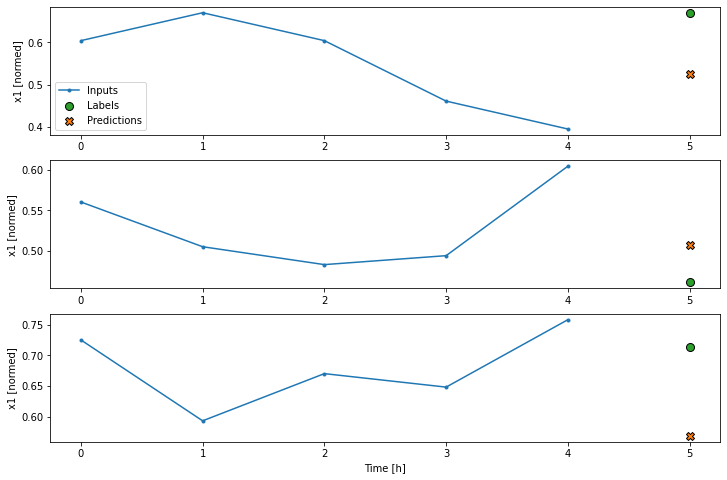

In [34]:
ventana.plot(lstm_model)

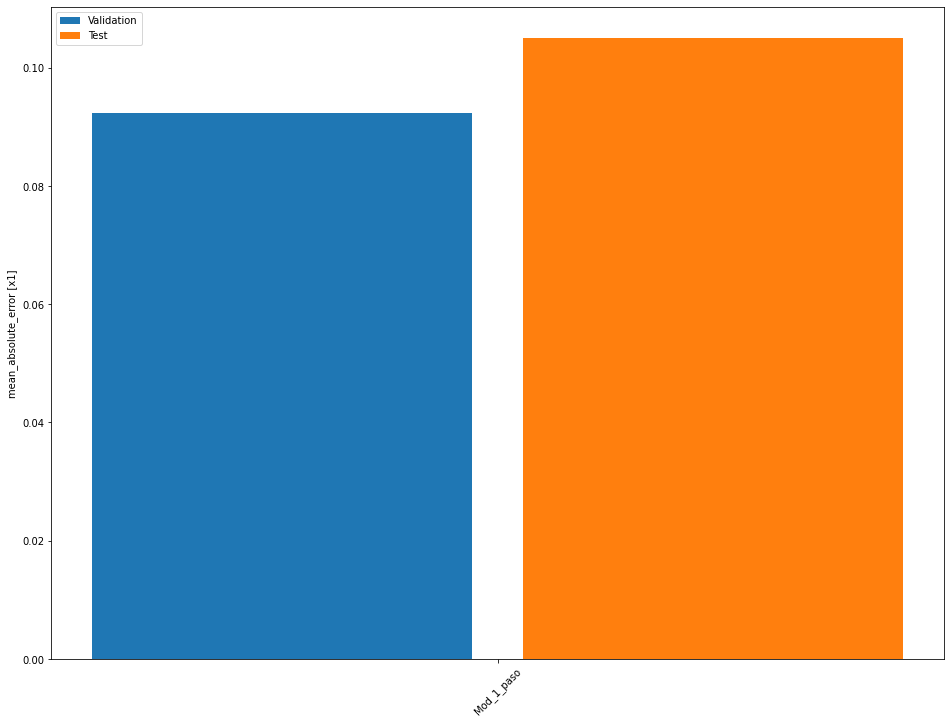

In [35]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [x1]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [36]:
history.epoch

[0, 1, 2, 3, 4]

In [37]:
history.history

{'loss': [0.02297070622444153,
  0.013296866789460182,
  0.012689896859228611,
  0.012296774424612522,
  0.011854509823024273],
 'mean_absolute_error': [0.11036644130945206,
  0.09019587188959122,
  0.08763466775417328,
  0.08627728372812271,
  0.08473905920982361],
 'val_loss': [0.014259484596550465,
  0.013394132256507874,
  0.012772958725690842,
  0.013194842264056206,
  0.013443900272250175],
 'val_mean_absolute_error': [0.0943622887134552,
  0.09065177291631699,
  0.08805736899375916,
  0.09100260585546494,
  0.09242144972085953]}

En este caso, y luego de probar varias estructuras y varios tamaños de batch encontramos que las predicciones no son satisfactorias notándose que la mejora en la pérdida no cambia después de 5 epochs.

#**9.2. Predicción de todas las variables un paso adelante**

## 9.2.1. Generación de una ventana multivariada en las variables a predecir. (Aun se predice un valor en el futuro)
Esto se hace no especificando labels o colocando labels_columns=None
Igualmente, se quiere predecir todas las variables un paso adelante dada una historia de 5 observaciones en el pasado

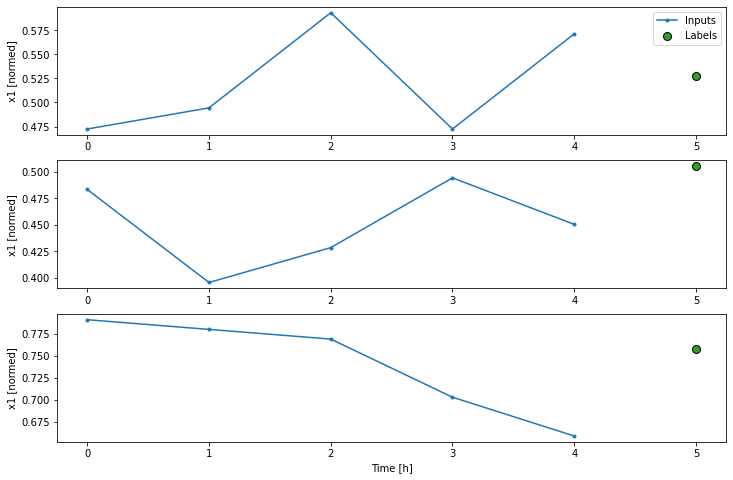

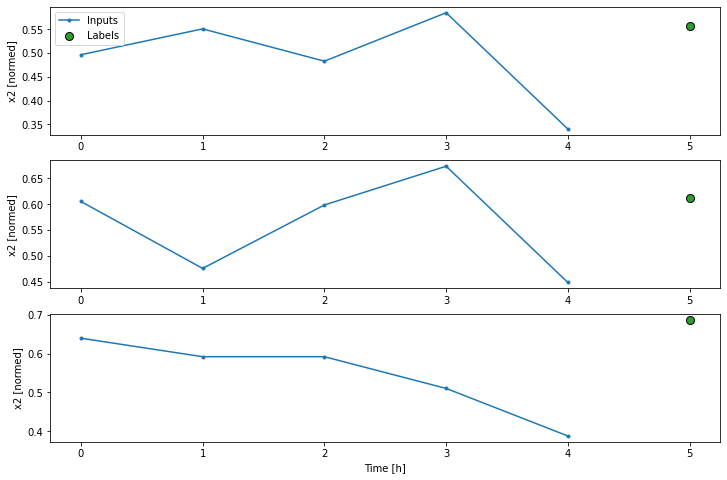

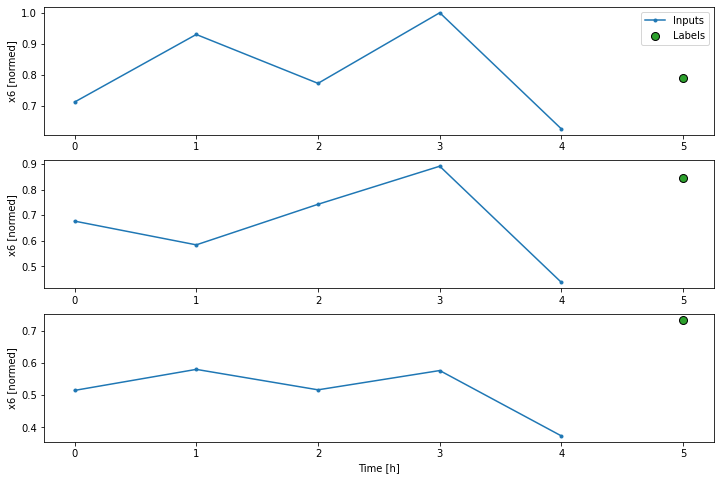

In [39]:
INPUTW=5
LABELW=1
SHIFTW=1
#Label columns=None toma todas las variables
#Cuando input y label son iguales, y shift =1 entonces es prediccion a un paso pero se grafica en el tiempo.
#Deben ser iguales, ademas es la predicción de 1 paso dado el paso anterior, ojo con eso


ventana = WindowGenerator(
    input_width=INPUTW,
    label_width=LABELW,
    shift=SHIFTW,
    label_columns=None)

ventana
ventana.plot()
ventana.plot(plot_col='x2')
ventana.plot(plot_col='x6')

In [40]:
for example_inputs, example_labels in ventana.train.take(2):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (8, 5, 7)
Labels shape (batch, time, features): (8, 1, 7)
Inputs shape (batch, time, features): (8, 5, 7)
Labels shape (batch, time, features): (8, 1, 7)


In [41]:
num_features

7

## 9.2.2. Modelo LSTM para predecir todos los features un período adelante (LW=1 , SHW=1)
Se siguieron las recomendaciones de dropout y activación antes comentadas

In [43]:
%%time
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, activation='relu'),
    tf.keras.layers.LSTM(32, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, activation='relu'),
    tf.keras.layers.LSTM(16, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, activation='relu'),
    tf.keras.layers.LSTM(8, return_sequences=False, dropout=0.2, recurrent_dropout=0.2, activation='relu'),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_features),
    tf.keras.layers.Reshape([1, -1])
])

#El reshape vuelve a la dimensión del tensor de salida original

print('Input shape:', ventana.example[0].shape)
print('Output shape:', lstm_model(ventana.example[0]).shape)

Input shape: (8, 5, 7)
Output shape: (8, 1, 7)
CPU times: user 1.06 s, sys: 222 ms, total: 1.28 s
Wall time: 1.18 s


## 9.2.3. Entrenamiento del modelo multivariable para predecir un valor en el futuro

In [44]:
  #para ejecutar hacer:
  history = compile_and_fit(lstm_model, ventana)
  val_performance = {}
  performance = {}
  IPython.display.clear_output()
  val_performance['Mod_mult_1_paso'] = lstm_model.evaluate(ventana.val)
  performance['Mod__mult1_paso'] = lstm_model.evaluate(ventana.test, verbose=1)

120/120 [==============================] - 1s 12ms/step - loss: 0.0173 - mean_absolute_error: 0.1001


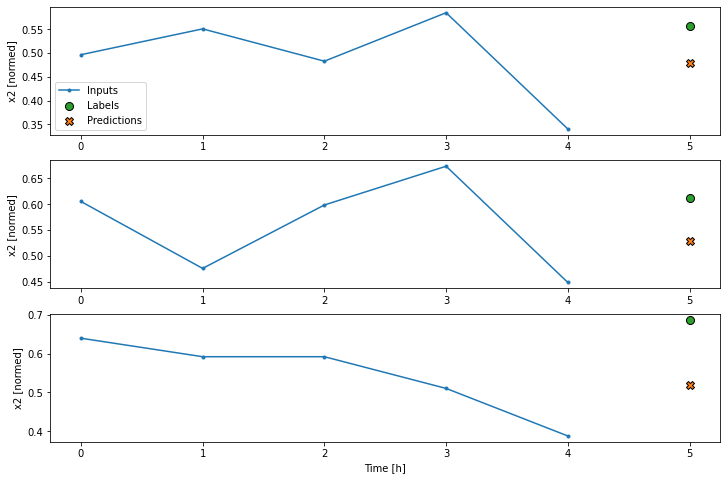

In [45]:
ventana.plot(lstm_model,plot_col='x2')

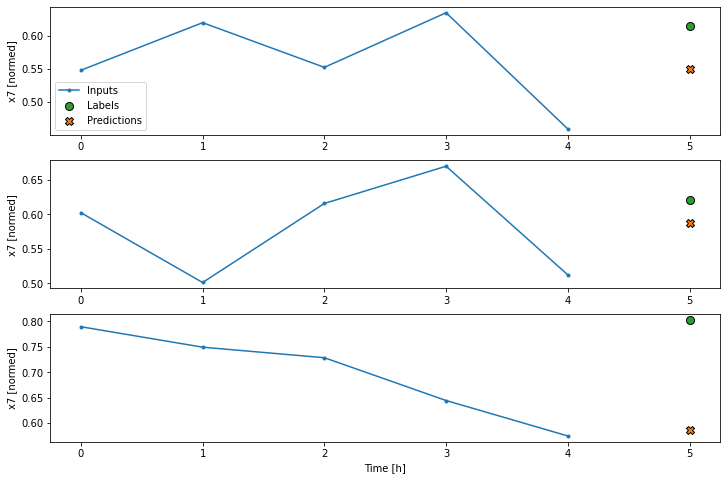

In [46]:
ventana.plot(lstm_model,plot_col='x7')

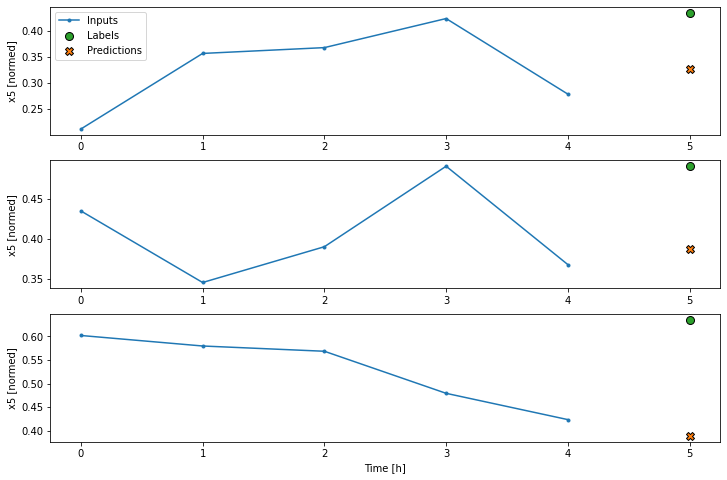

In [47]:
ventana.plot(lstm_model,plot_col='x5')

In [48]:
history.epoch

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [49]:
history.history

{'loss': [0.039980437606573105,
  0.015963038429617882,
  0.015016576275229454,
  0.014491243287920952,
  0.014138642698526382,
  0.013793699443340302,
  0.013568306341767311,
  0.013386105187237263,
  0.013146751560270786,
  0.012956572696566582],
 'mean_absolute_error': [0.1389618217945099,
  0.09589578211307526,
  0.09245666116476059,
  0.09065714478492737,
  0.08911789208650589,
  0.08794869482517242,
  0.08698578923940659,
  0.0863393247127533,
  0.08542098104953766,
  0.08478336781263351],
 'val_loss': [0.02055865339934826,
  0.017992263659834862,
  0.016757134348154068,
  0.017275061458349228,
  0.01602269522845745,
  0.016041483730077744,
  0.014503645710647106,
  0.01396679412573576,
  0.015545187518000603,
  0.014484196901321411],
 'val_mean_absolute_error': [0.11192344129085541,
  0.10303408652544022,
  0.09792880713939667,
  0.1001758724451065,
  0.09581036865711212,
  0.09676068276166916,
  0.08909907937049866,
  0.08730019629001617,
  0.09453755617141724,
  0.090613871812

En este caso, y luego de probar varias estructuras y varios tamaños de batch encontramos que las predicciones no son satisfactorias notándose que la mejora en la pérdida no cambia después de 10 epochs. Es positivo el hecho que no hay sobre ajuste dado que se utilizaron Drop-Outs

#**9.3. Predicción de una variable varios pasos adelante**

 ## 9.3.1. Ventana para un modelo de una variable que predice varios valores en el futuro
 La ventana captura todas las variables pero solo genera labels para una de ellas.
 Queremos predecir 3 valores en el futuro basados en una historia de 10 pasos atrás de la variable x7

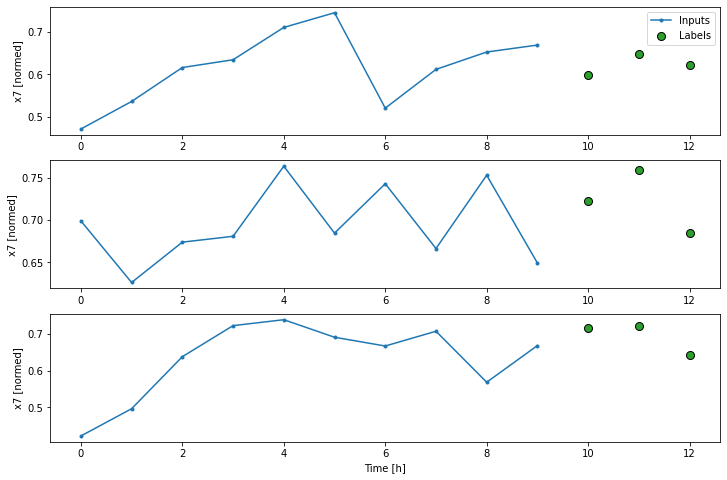

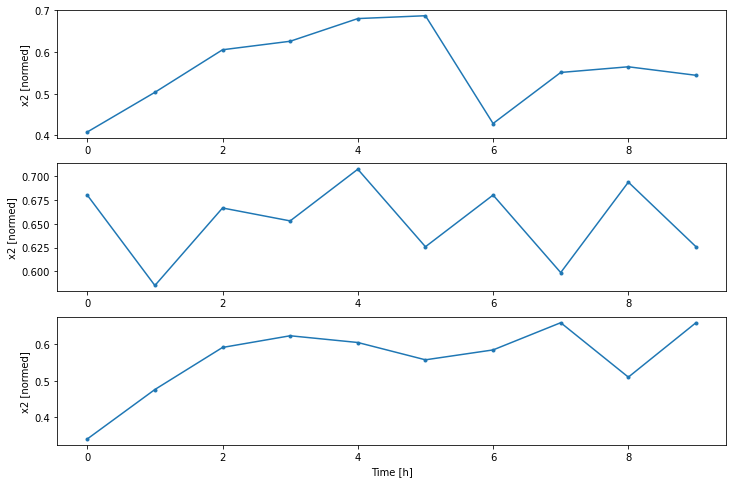

In [50]:
INPUTW=10
LABELW=3
SHIFTW=3
#Label columns=None toma todas las variables
#Cuando input y label son iguales, y shift =1 entonces es prediccion a un paso pero se grafica en el tiempo.
#Deben ser iguales, ademas es la predicción de 1 paso dado el paso anterior, ojo con eso
# LABEL Y SHITF DEBEN SER IGUALES

ventana = WindowGenerator(
    input_width=INPUTW,
    label_width=LABELW,
    shift=SHIFTW,
    label_columns=['x7'])

ventana
ventana.plot(plot_col='x7')
ventana.plot(plot_col='x2')

In [52]:
for example_inputs, example_labels in ventana.train.take(5):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (8, 10, 7)
Labels shape (batch, time, features): (8, 3, 1)
Inputs shape (batch, time, features): (8, 10, 7)
Labels shape (batch, time, features): (8, 3, 1)
Inputs shape (batch, time, features): (8, 10, 7)
Labels shape (batch, time, features): (8, 3, 1)
Inputs shape (batch, time, features): (8, 10, 7)
Labels shape (batch, time, features): (8, 3, 1)
Inputs shape (batch, time, features): (8, 10, 7)
Labels shape (batch, time, features): (8, 3, 1)


## 9.3.2. Modelo que predice varios valores en el futuro para una sola variable
Se continúa con las recomendaciones de dropout y activación

In [55]:
%%time

multi_lstm_model = tf.keras.Sequential([
    #Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, activation='relu'),
    tf.keras.layers.LSTM(32, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, activation='relu'),
    tf.keras.layers.LSTM(16, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, activation='relu'),
    tf.keras.layers.LSTM(8, return_sequences=False, dropout=0.2, recurrent_dropout=0.2, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(LABELW,),
                          
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([LABELW, 1])
])

print('Input shape:', ventana.example[0].shape)
print('Output shape:', multi_lstm_model(ventana.example[0]).shape)

Input shape: (8, 10, 7)
Output shape: (8, 3, 1)
CPU times: user 1.42 s, sys: 364 ms, total: 1.79 s
Wall time: 1.6 s


## 9.3.3. Entrenamiento modelo univariable para predecir varios pasos en el futuro

In [56]:
history = compile_and_fit(multi_lstm_model, ventana)

multi_val_performance={}
multi_performance={}
IPython.display.clear_output()
multi_val_performance['Mod_uni_varios'] = multi_lstm_model.evaluate(ventana.val)
multi_performance['Mod_uni_varios'] = multi_lstm_model.evaluate(ventana.test, verbose=0)


239/239 [==============================] - 3s 14ms/step - loss: 0.0124 - mean_absolute_error: 0.0932


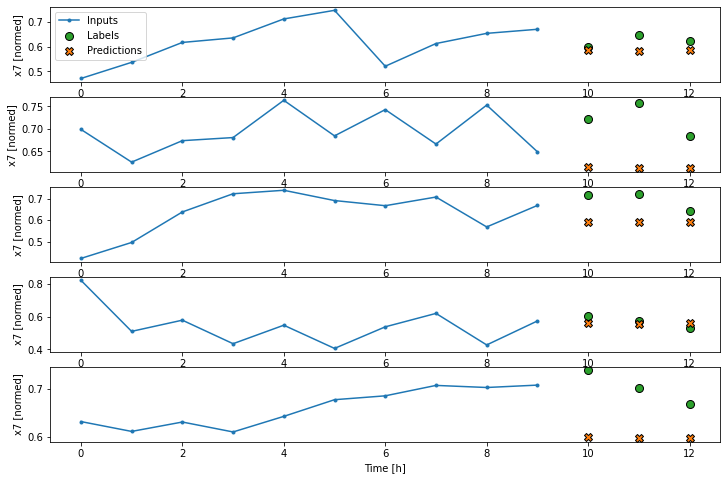

In [58]:
ventana.plot(multi_lstm_model,max_subplots=5,plot_col='x7')

In [59]:
history.epoch

[0, 1, 2, 3, 4]

In [60]:
history.history

{'loss': [0.026053721085190773,
  0.01203089114278555,
  0.011334123089909554,
  0.011022436432540417,
  0.010747631080448627],
 'mean_absolute_error': [0.11351141333580017,
  0.0854433998465538,
  0.08267147839069366,
  0.08150313794612885,
  0.08031973242759705],
 'val_loss': [0.011606050655245781,
  0.011956026777625084,
  0.011559243313968182,
  0.012423454783856869,
  0.012384163215756416],
 'val_mean_absolute_error': [0.0891909971833229,
  0.09088834375143051,
  0.08896736800670624,
  0.09326235204935074,
  0.09315373748540878]}

Las predicciones siguen siendo insatisfactorias pero por lo menos el modelo no se está sobreajsutando.

#**9.4. Predicción de varias variables varios pasos adelante**

## 9.4.1. Ventana mulitvariable multipaso
Queremos predecir todas las variables 3 pasos adelante basados en una historia 7 pasos atrás

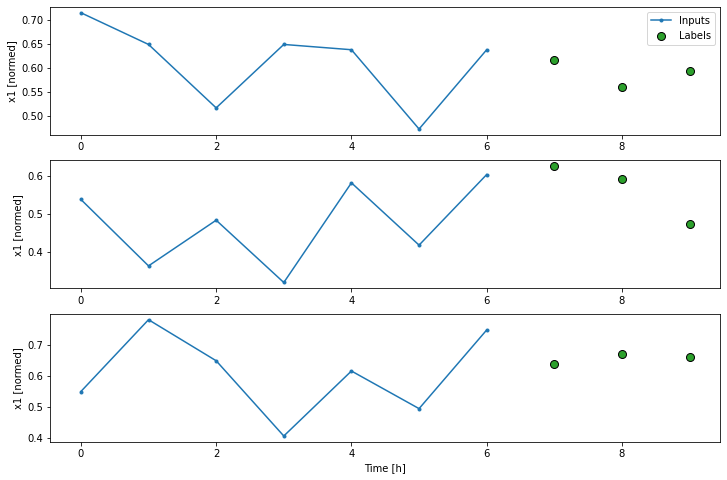

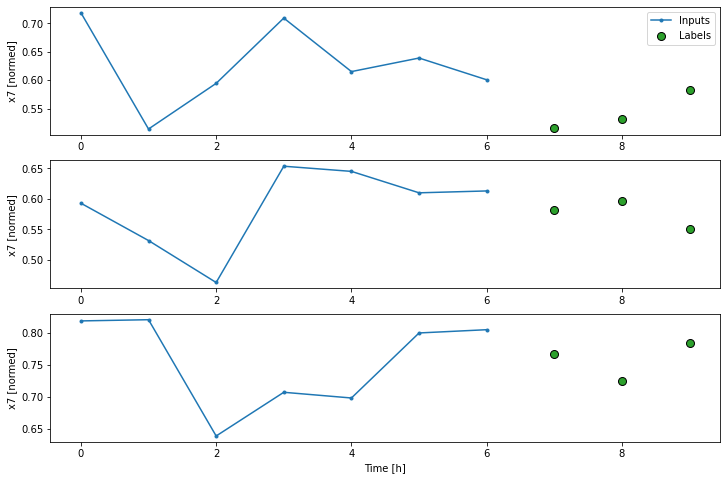

In [62]:
INPUTW=7
LABELW=3
SHIFTW=3
#Label columns=None toma todas las variables
#Cuando input y label son iguales, y shift =1 entonces es prediccion a un paso pero se grafica en el tiempo.
#Deben ser iguales, ademas es la predicción de 1 paso dado el paso anterior, ojo con eso
# LABEL Y SHITF DEBEN SER IGUALES

ventana = WindowGenerator(
    input_width=INPUTW,
    label_width=LABELW,
    shift=SHIFTW,
    label_columns=None)

ventana
ventana.plot()
ventana.plot(plot_col='x7')

## 9.4.2. Modelo multivariable multipaso

In [69]:
%%time

multi_lstm_model = tf.keras.Sequential([
    #Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(64, return_sequences=True, dropout=0.3, recurrent_dropout=0.3, activation='relu'),
    tf.keras.layers.LSTM(32, return_sequences=True, dropout=0.3, recurrent_dropout=0.3, activation='relu'),
    tf.keras.layers.LSTM(16, return_sequences=True, dropout=0.3, recurrent_dropout=0.3, activation='relu'),
    tf.keras.layers.LSTM(8, return_sequences=False, dropout=0.3, recurrent_dropout=0.3, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(LABELW*num_features,),
                          
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([LABELW, num_features])
])

print('Input shape:', ventana.example[0].shape)
print('Output shape:', multi_lstm_model(ventana.example[0]).shape)

Input shape: (8, 7, 7)
Output shape: (8, 3, 7)
CPU times: user 1.22 s, sys: 231 ms, total: 1.45 s
Wall time: 1.31 s


## 9.4.3. Entrenamiento modelo multivariable multipaso

In [70]:
history = compile_and_fit(multi_lstm_model, ventana)

multi_val_performance={}
multi_performance={}
IPython.display.clear_output()
multi_val_performance['Mod_uni_varios'] = multi_lstm_model.evaluate(ventana.val)
multi_performance['Mod_uni_varios'] = multi_lstm_model.evaluate(ventana.test, verbose=0)

239/239 [==============================] - 3s 12ms/step - loss: 0.0155 - mean_absolute_error: 0.0946


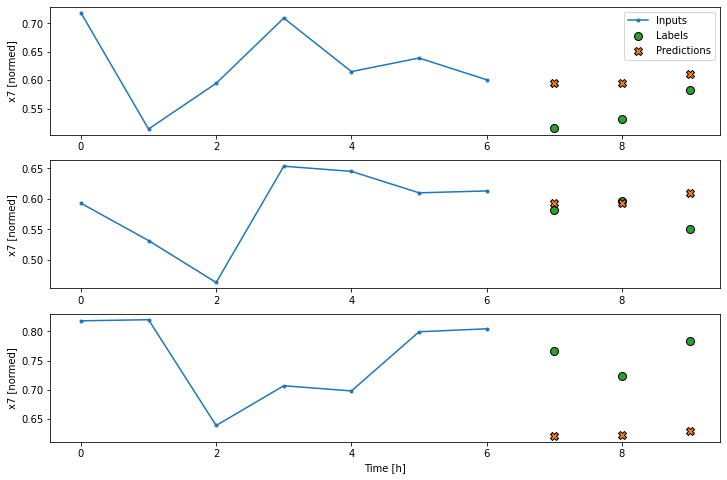

In [71]:
ventana.plot(multi_lstm_model,plot_col='x7')

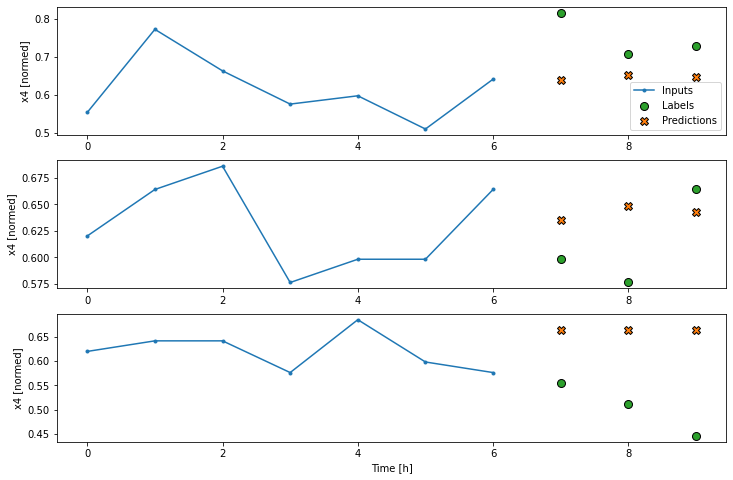

In [66]:
ventana.plot(multi_lstm_model,plot_col='x4')

In [72]:
history.epoch

[0, 1, 2, 3, 4, 5, 6, 7, 8]

In [73]:
history.history

{'loss': [0.050277452915906906,
  0.016464192420244217,
  0.01580621488392353,
  0.015133559703826904,
  0.014539516530930996,
  0.014272455126047134,
  0.013994475826621056,
  0.013865613378584385,
  0.013769897632300854],
 'mean_absolute_error': [0.1519707292318344,
  0.0973161906003952,
  0.09512844681739807,
  0.09291806071996689,
  0.09078294783830643,
  0.0898512527346611,
  0.08888906985521317,
  0.08837264031171799,
  0.08798184245824814],
 'val_loss': [0.02138162963092327,
  0.01960071176290512,
  0.019440913572907448,
  0.01747056655585766,
  0.0163978673517704,
  0.01605897955596447,
  0.014989272691309452,
  0.01525365374982357,
  0.015480509959161282],
 'val_mean_absolute_error': [0.11457008123397827,
  0.10605528205633163,
  0.10679608583450317,
  0.10124396532773972,
  0.09761632978916168,
  0.09642805904150009,
  0.09197792410850525,
  0.09337013214826584,
  0.09457413107156754]}

Se incrementó la fracción en el dropout de 0.2 a 0.3 para reducir el sobre ajuste. Se logró el cometido aunque las predicciones siguen siendo insatisfactorias